In [1]:
from matplotlib import pyplot as plt
import numpy as np
import torch
from torch import nn,optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os
from PIL import Image

/home/users/lqa/miniconda3/envs/DataScience/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
args = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'batch_size': 64,
    # 'test_batch_size': 1000,
    'epochs': 20,
    'lr': 1e-4
}

model_urls = {"resnet34":"https://download.pytorch.org/models/resnet34-b627a593.pth"}
model = models.resnet34(pretrained = True).to(args["device"])

print(model)
# trans = transforms.ToTensor()
# test_dataset = datasets.FashionMNIST(root='../Task1/dataset', train=False,
#                                 transform = trans, download=True)
# test_loader = DataLoader(dataset=test_dataset,
#                          batch_size=args["batch_size"], shuffle=True)

# def test_loop(model, test_loader, loss_fn, device):
#     size = len(test_loader.dataset)
#     test_loss, correct = 0,0
#     model.eval()

#     with torch.no_grad():
#         for x,y in test_loader:
#             x, y = x.to(device), y.to(device)
#             logits, pred = model.forward(x)
#             y_pred = pred.argmax(dim=1)
#             # print(pred.shape)

#             test_loss += loss_fn(pred,y).item() * len(x)
#             correct += (y_pred == y).type(torch.float).sum().item()
#     test_loss /= size
#     correct /= size

#     print(f'Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n')

# loss_fn = nn.CrossEntropyLoss()
# test_loop(model, test_loader, loss_fn, args["device"])



/home/users/lqa/miniconda3/envs/DataScience/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/users/lqa/miniconda3/envs/DataScience/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
print(hasattr(model.layer4[2].relu, 'register_full_backward_hook'))
print(hasattr(model.layer4[2].relu, 'register_backward_hook'))


True
True


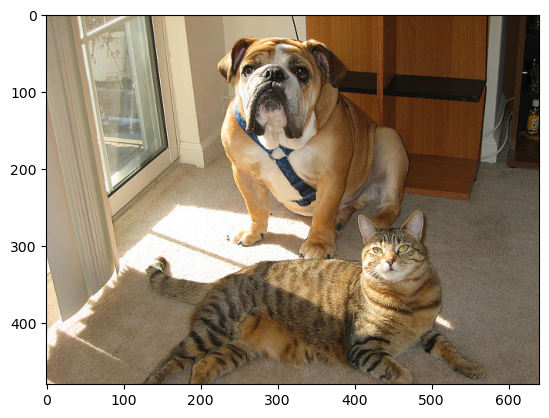


conv1
bn1
relu
maxpool
layer1
layer1.0
layer1.0.conv1
layer1.0.bn1
layer1.0.relu
layer1.0.conv2
layer1.0.bn2
layer1.1
layer1.1.conv1
layer1.1.bn1
layer1.1.relu
layer1.1.conv2
layer1.1.bn2
layer1.2
layer1.2.conv1
layer1.2.bn1
layer1.2.relu
layer1.2.conv2
layer1.2.bn2
layer2
layer2.0
layer2.0.conv1
layer2.0.bn1
layer2.0.relu
layer2.0.conv2
layer2.0.bn2
layer2.0.downsample
layer2.0.downsample.0
layer2.0.downsample.1
layer2.1
layer2.1.conv1
layer2.1.bn1
layer2.1.relu
layer2.1.conv2
layer2.1.bn2
layer2.2
layer2.2.conv1
layer2.2.bn1
layer2.2.relu
layer2.2.conv2
layer2.2.bn2
layer2.3
layer2.3.conv1
layer2.3.bn1
layer2.3.relu
layer2.3.conv2
layer2.3.bn2
layer3
layer3.0
layer3.0.conv1
layer3.0.bn1
layer3.0.relu
layer3.0.conv2
layer3.0.bn2
layer3.0.downsample
layer3.0.downsample.0
layer3.0.downsample.1
layer3.1
layer3.1.conv1
layer3.1.bn1
layer3.1.relu
layer3.1.conv2
layer3.1.bn2
layer3.2
layer3.2.conv1
layer3.2.bn1
layer3.2.relu
layer3.2.conv2
layer3.2.bn2
layer3.3
layer3.3.conv1
layer3.3.bn1


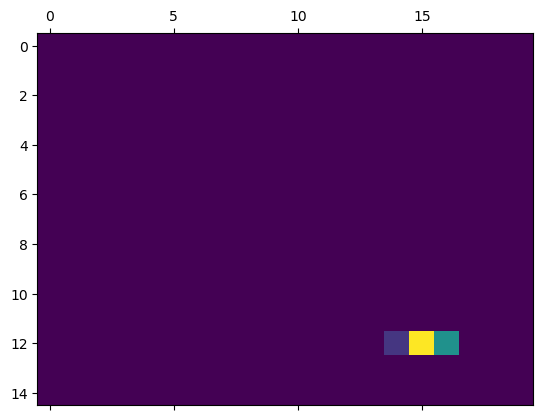

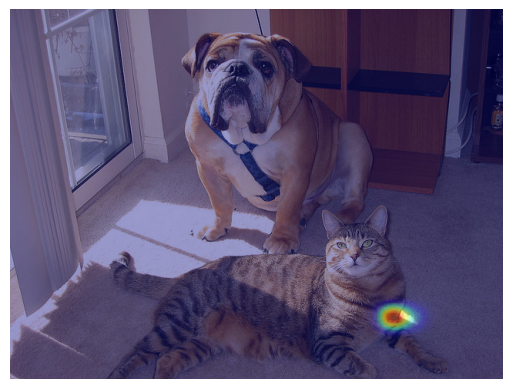

In [15]:
"""
Task 3.4: Grad-CAM
""" 

cat_dog = Image.open("./dataset/cat_dog.jpg")
cat_dog = torch.from_numpy(np.array(cat_dog))
plt.imshow(cat_dog)
plt.show()

model.eval()
loss_fn = nn.CrossEntropyLoss()
y_cat = torch.zeros(1000)
y_cat[282] = 1
features_in_hook = []
features_out_hook = []
gradients_in_hook = []
gradients_out_hook = []
def hook_forward(module, fea_in, fea_out):
    features_in_hook.append(fea_in)         # 勾的是指定层的输入
    # 只取前向传播的数值
    features_out_hook.append(fea_out)      # 勾的是指定层的输出
    return None
def hook_backward(module, grad_in, grad_out):
    # print(f"grad_in:{grad_in}")
    gradients_in_hook.append(grad_in)
    gradients_out_hook.append(grad_out)
    return None
layer_name = "layer4.2.conv1"
# layer_name = "layer4.2.conv2"
for (name, module) in model.named_modules():
    print(name)
    if name == layer_name:
        hf = module.register_forward_hook(hook=hook_forward)
        hb = module.register_backward_hook(hook=hook_backward)

logits = model.forward(cat_dog.permute([2,0,1]).unsqueeze(dim=0).type(torch.float).to(args["device"]))
hf.remove()
print(logits)
print(logits.shape)

# calculate gradient of each layer
# https://stackoverflow.com/questions/67722328/how-to-check-the-output-gradient-by-each-layer-in-pytorch-in-my-code
# https://discuss.pytorch.org/t/how-can-i-get-the-gradients-of-the-weights-of-each-layer/28502

# layer_name = "layer4.2.relu"
# for (name, module) in model.named_modules():
#     print(name)
#     if name == layer_name:
#         # hf = module.register_forward_hook(hook=hook_forward)
#         hb = module.register_full_backward_hook(hook=hook_backward)
# loss = loss_fn(logits, y_cat.to(args["device"]))
loss = logits @ y_cat.to(args['device'])
loss.backward()
hb.remove()
# print(model.layer4[2].relu.grad)
# print(model.layer4[2].relu.grad.shape)
print(features_out_hook[0].squeeze(dim=0))
print(features_out_hook[0].squeeze(dim=0).shape)
# print(features_out_hook[0].sum())
print(gradients_out_hook[0][0])
print(gradients_out_hook[0][0].shape)

alpha_cat = gradients_out_hook[0][0].mean(dim=[2,3], keepdim=True).squeeze(dim=0)
print(alpha_cat.shape)

L = F.relu(alpha_cat.mul(features_out_hook[0].squeeze(dim=0)).sum(dim=0))
print(L)
L /= torch.max(L)
plt.matshow(L.detach().cpu())

# 整合
from torchvision.transforms.functional import to_pil_image
from matplotlib import colormaps
fig, ax = plt.subplots()
ax.axis('off')

ax.imshow(to_pil_image(cat_dog.permute([2,0,1]), mode='RGB'))

overlay = to_pil_image(L.detach().cpu(), mode='F').resize((640, 480), resample=Image.BICUBIC)

cmap = colormaps['jet']
overlay = (255*cmap(np.asarray(overlay) ** 2)[:,:,:3]).astype(np.uint8)

ax.imshow(overlay, alpha=0.4, interpolation="nearest")

plt.show()



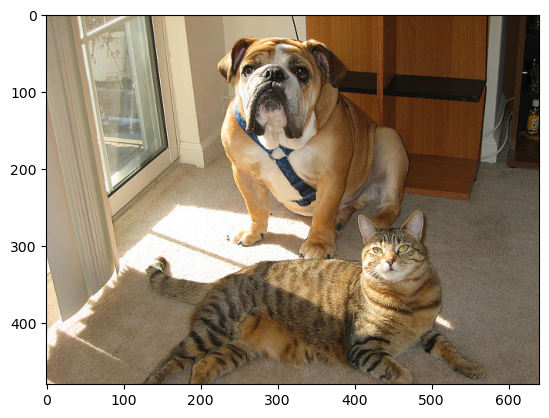

tensor([[-5.8126e+01,  1.2704e+01, -4.2646e+01, -5.0440e+01, -6.4614e-01,
         -2.1339e+01, -2.1731e+01,  2.3116e+01, -1.4632e+01, -4.0000e+01,
         -4.6517e+01, -2.4258e+01, -4.6936e+01, -4.1814e+01, -5.9140e+01,
          1.4784e+00, -1.8814e+01, -4.9730e+01, -1.5194e+01, -4.9270e+01,
         -3.1923e+01, -6.2725e+01, -5.2043e+01, -1.5392e+01, -5.4735e+01,
         -2.5728e+01, -4.0288e+01, -1.0616e+01, -7.0277e+00, -4.4692e+00,
         -2.4406e+01,  5.2425e+00, -1.5336e+01, -2.3791e+01, -4.1974e+00,
         -3.8641e+01, -3.2039e-01, -1.1589e+01, -1.8131e+01, -1.4510e+01,
         -1.2410e+01, -3.0507e+01, -1.8296e+01, -2.2817e+01, -7.8551e+00,
         -2.1277e+01,  1.1560e+01, -3.0285e+01, -3.2732e+01, -2.4315e+00,
         -2.4760e+01, -4.3822e+00, -3.1270e+00, -5.8101e+00,  1.8200e+01,
          1.5158e+01, -1.8704e+01, -2.9235e+01, -5.4494e+01,  1.9792e+01,
          3.4629e+01, -7.2205e+01, -1.9606e+01, -3.1283e+01, -2.9544e+01,
         -1.1145e+01, -1.4464e+01, -3.

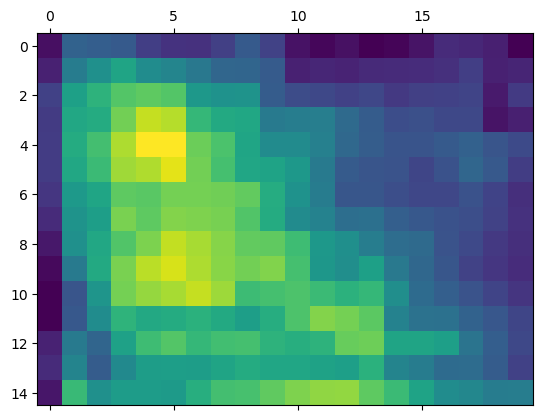

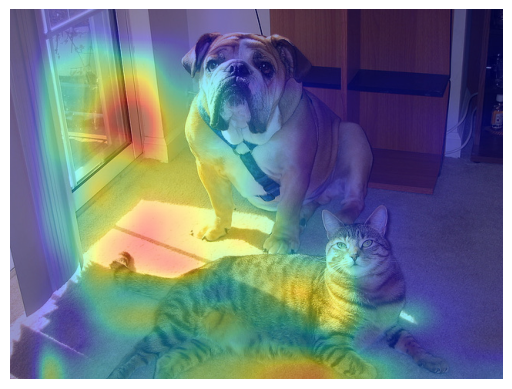

In [23]:
"""
Task 3.4: Grad-CAM
""" 

cat_dog = Image.open("./dataset/cat_dog.jpg")
cat_dog = torch.from_numpy(np.array(cat_dog))
plt.imshow(cat_dog)
plt.show()

model.eval()
loss_fn = nn.CrossEntropyLoss()
y_cat = torch.zeros(1000)
y_cat[282] = 1
features_in_hook = []
features_out_hook = []
gradients_in_hook = []
gradients_out_hook = []
def hook_forward(module, fea_in, fea_out):
    features_in_hook.append(fea_in)         # 勾的是指定层的输入
    # 只取前向传播的数值
    features_out_hook.append(fea_out)      # 勾的是指定层的输出
    return None
def hook_backward(module, grad_in, grad_out):
    # print(f"grad_in:{grad_in}")
    gradients_in_hook.append(grad_in)
    gradients_out_hook.append(grad_out)
    return None

# hf = model.layer4[2].register_forward_hook(hook=hook_forward)
# hb = model.layer4[2].register_backward_hook(hook=hook_backward)
hf = model.layer4[-1].register_forward_hook(hook=hook_forward)
hb = model.layer4[-1].register_backward_hook(hook=hook_backward)
# layer_name = "layer4.2.conv1"
# # layer_name = "layer4.2.conv2"
# for (name, module) in model.named_modules():
#     print(name)
#     if name == layer_name:
#         hf = module.register_forward_hook(hook=hook_forward)
#         hb = module.register_backward_hook(hook=hook_backward)

logits = model.forward(cat_dog.permute([2,0,1]).unsqueeze(dim=0).type(torch.float).to(args["device"]))
hf.remove()
print(logits)
print(logits.shape)

# calculate gradient of each layer
# https://stackoverflow.com/questions/67722328/how-to-check-the-output-gradient-by-each-layer-in-pytorch-in-my-code
# https://discuss.pytorch.org/t/how-can-i-get-the-gradients-of-the-weights-of-each-layer/28502

loss = logits @ y_cat.to(args['device'])
loss.backward()
hb.remove()
# print(model.layer4[2].relu.grad)
# print(model.layer4[2].relu.grad.shape)
print(features_out_hook[0].squeeze(dim=0))
print(features_out_hook[0].squeeze(dim=0).shape)
# print(features_out_hook[0].sum())
print(gradients_out_hook[0][0])
print(gradients_out_hook[0][0].shape)

alpha_cat = gradients_out_hook[0][0].detach().mean(dim=[2,3], keepdim=True).squeeze(dim=0)
print(alpha_cat.shape)

L = F.relu(alpha_cat.mul(features_out_hook[0].squeeze(dim=0)).sum(dim=0))
print(L)
L /= torch.max(L)
plt.matshow(L.detach().cpu())

# 整合
from torchvision.transforms.functional import to_pil_image
from matplotlib import colormaps
fig, ax = plt.subplots()
ax.axis('off')

ax.imshow(to_pil_image(cat_dog.permute([2,0,1]), mode='RGB'))

overlay = to_pil_image(L.detach().cpu(), mode='F').resize((640, 480), resample=Image.BICUBIC)

cmap = colormaps['jet']
overlay = (255*cmap(np.asarray(overlay) ** 2)[:,:,:3]).astype(np.uint8)

ax.imshow(overlay, alpha=0.4, interpolation="nearest")

plt.show()



torch.Size([500, 494, 3])


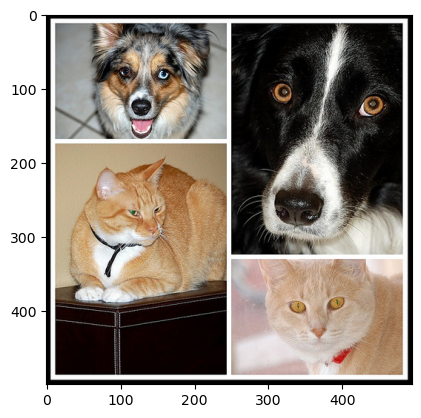

/home/users/lqa/miniconda3/envs/DataScience/lib/python3.9/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


tensor([[-6.4995e+01,  1.0091e+01, -3.7367e+01, -6.1069e+01, -8.5821e+00,
         -1.9022e+01, -3.0923e+01,  1.5361e+01, -1.7430e+01, -4.6793e+01,
         -5.3072e+01, -2.6879e+01, -5.4381e+01, -4.2944e+01, -6.6759e+01,
         -1.4201e-01, -1.6449e+01, -5.7217e+01, -1.7236e+01, -5.8094e+01,
         -4.0385e+01, -6.7550e+01, -4.7271e+01, -1.4249e+01, -6.5279e+01,
         -2.2770e+01, -5.3544e+01, -1.7123e+01, -2.3304e+00, -1.2915e+01,
         -2.9165e+01,  4.7609e+00, -2.0077e+01, -2.3287e+01, -5.3470e+00,
         -3.4602e+01,  5.6191e-01, -2.6397e+00, -2.5962e+01, -1.6474e+01,
         -2.1202e+01, -4.4865e+01, -2.4304e+01, -2.5525e+01, -1.2409e+01,
         -1.6438e+01,  1.2063e+01, -4.0555e+01, -3.4777e+01, -5.0720e+00,
         -2.7399e+01, -8.0562e-01, -8.7926e+00, -1.5716e+01,  1.3819e+01,
          1.2759e+01, -2.1175e+01, -4.1939e+01, -6.1089e+01,  2.1237e+01,
          3.7938e+01, -8.6057e+01, -2.9307e+01, -3.5904e+01, -2.4120e+01,
         -1.2160e+01, -1.8807e+01, -3.

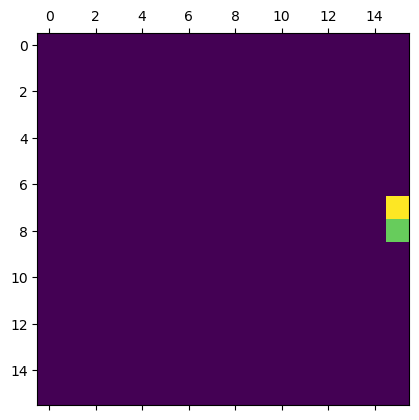

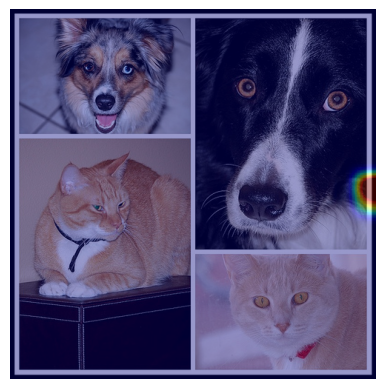

In [28]:
"""
Task 3.4: Grad-CAM
""" 

tabbycat_dog = Image.open("./dataset/tabbycat_dog.jpg")
tabbycat_dog = torch.from_numpy(np.array(tabbycat_dog))
print(tabbycat_dog.shape)
plt.imshow(tabbycat_dog)
plt.show()

model.eval()
loss_fn = nn.CrossEntropyLoss()
y_cat = torch.zeros(1000)
y_cat[281] = 1
features_in_hook = []
features_out_hook = []
gradients_in_hook = []
gradients_out_hook = []
def hook_forward(module, fea_in, fea_out):
    features_in_hook.append(fea_in)         # 勾的是指定层的输入
    # 只取前向传播的数值
    features_out_hook.append(fea_out)      # 勾的是指定层的输出
    return None
def hook_backward(module, grad_in, grad_out):
    # print(f"grad_in:{grad_in}")
    gradients_in_hook.append(grad_in)
    gradients_out_hook.append(grad_out)
    return None

# hf = model.layer4[2].register_forward_hook(hook=hook_forward)
# hb = model.layer4[2].register_backward_hook(hook=hook_backward)
hf = model.layer4[-1].register_forward_hook(hook=hook_forward)
hb = model.layer4[-1].register_backward_hook(hook=hook_backward)
# layer_name = "layer4.2.conv1"
# # layer_name = "layer4.2.conv2"
# for (name, module) in model.named_modules():
#     print(name)
#     if name == layer_name:
#         hf = module.register_forward_hook(hook=hook_forward)
#         hb = module.register_backward_hook(hook=hook_backward)

logits = model.forward(tabbycat_dog.permute([2,0,1]).unsqueeze(dim=0).type(torch.float).to(args["device"]))
hf.remove()
print(logits)
print(logits.shape)

# calculate gradient of each layer
# https://stackoverflow.com/questions/67722328/how-to-check-the-output-gradient-by-each-layer-in-pytorch-in-my-code
# https://discuss.pytorch.org/t/how-can-i-get-the-gradients-of-the-weights-of-each-layer/28502

loss = logits @ y_cat.to(args['device'])
loss.backward()
hb.remove()
# print(model.layer4[2].relu.grad)
# print(model.layer4[2].relu.grad.shape)
print(features_out_hook[0].squeeze(dim=0))
print(features_out_hook[0].squeeze(dim=0).shape)
# print(features_out_hook[0].sum())
print(gradients_out_hook[0][0])
print(gradients_out_hook[0][0].shape)

alpha_cat = gradients_out_hook[0][0].detach().mean(dim=[2,3], keepdim=True).squeeze(dim=0)
print(alpha_cat.shape)

L = F.relu(alpha_cat.mul(features_out_hook[0].squeeze(dim=0)).sum(dim=0))
print(L)
L /= torch.max(L)
plt.matshow(L.detach().cpu())

# 整合
from torchvision.transforms.functional import to_pil_image
from matplotlib import colormaps
fig, ax = plt.subplots()
ax.axis('off')

ax.imshow(to_pil_image(tabbycat_dog.permute([2,0,1]), mode='RGB'))

overlay = to_pil_image(L.detach().cpu(), mode='F').resize((494, 500), resample=Image.BICUBIC)

cmap = colormaps['jet']
overlay = (255*cmap(np.asarray(overlay) ** 2)[:,:,:3]).astype(np.uint8)

ax.imshow(overlay, alpha=0.4, interpolation="nearest")

plt.show()



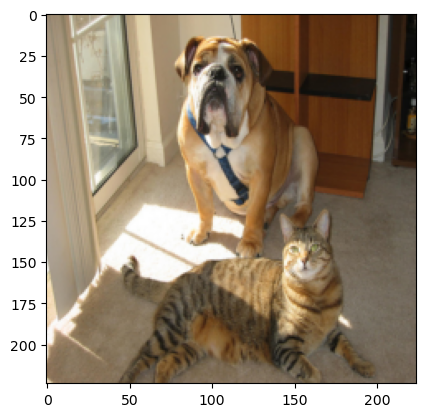


conv1
bn1
relu
maxpool
layer1
layer1.0
layer1.0.conv1
layer1.0.bn1
layer1.0.relu
layer1.0.conv2
layer1.0.bn2
layer1.1
layer1.1.conv1
layer1.1.bn1
layer1.1.relu
layer1.1.conv2
layer1.1.bn2
layer1.2
layer1.2.conv1
layer1.2.bn1
layer1.2.relu
layer1.2.conv2
layer1.2.bn2
layer2
layer2.0
layer2.0.conv1
layer2.0.bn1
layer2.0.relu
layer2.0.conv2
layer2.0.bn2
layer2.0.downsample
layer2.0.downsample.0
layer2.0.downsample.1
layer2.1
layer2.1.conv1
layer2.1.bn1
layer2.1.relu
layer2.1.conv2
layer2.1.bn2
layer2.2
layer2.2.conv1
layer2.2.bn1
layer2.2.relu
layer2.2.conv2
layer2.2.bn2
layer2.3
layer2.3.conv1
layer2.3.bn1
layer2.3.relu
layer2.3.conv2
layer2.3.bn2
layer3
layer3.0
layer3.0.conv1
layer3.0.bn1
layer3.0.relu
layer3.0.conv2
layer3.0.bn2
layer3.0.downsample
layer3.0.downsample.0
layer3.0.downsample.1
layer3.1
layer3.1.conv1
layer3.1.bn1
layer3.1.relu
layer3.1.conv2
layer3.1.bn2
layer3.2
layer3.2.conv1
layer3.2.bn1
layer3.2.relu
layer3.2.conv2
layer3.2.bn2
layer3.3
layer3.3.conv1
layer3.3.bn1


/home/users/lqa/miniconda3/envs/DataScience/lib/python3.9/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


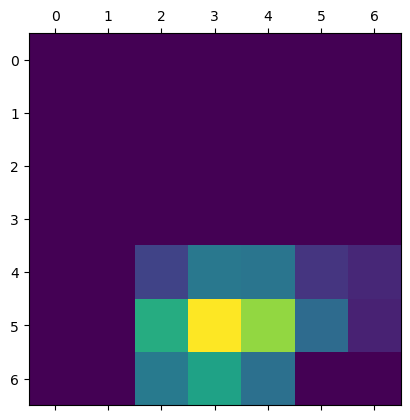

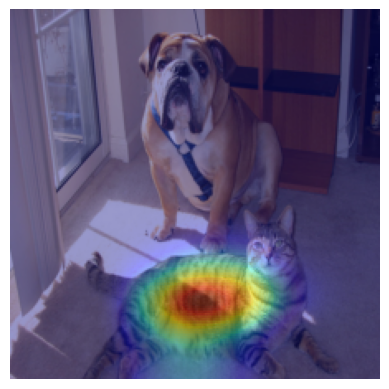

In [4]:
# 20230503 重新整合：加入trans
"""
Task 3.4: Grad-CAM
""" 

image = Image.open("./dataset/cat_dog.jpg")
trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
image = trans(image)

cat_dog = image.permute(1,2,0)

# cat_dog = torch.from_numpy(np.array(cat_dog))
plt.imshow(cat_dog)
plt.show()

model.eval()
loss_fn = nn.CrossEntropyLoss()
y_cat = torch.zeros(1000)
y_cat[282] = 1
features_in_hook = []
features_out_hook = []
gradients_in_hook = []
gradients_out_hook = []
def hook_forward(module, fea_in, fea_out):
    features_in_hook.append(fea_in)         # 勾的是指定层的输入
    # 只取前向传播的数值
    features_out_hook.append(fea_out)      # 勾的是指定层的输出
    return None
def hook_backward(module, grad_in, grad_out):
    # print(f"grad_in:{grad_in}")
    gradients_in_hook.append(grad_in)
    gradients_out_hook.append(grad_out)
    return None
layer_name = "layer4.2.conv1"
# layer_name = "layer4.2.conv2"
for (name, module) in model.named_modules():
    print(name)
    if name == layer_name:
        hf = module.register_forward_hook(hook=hook_forward)
        hb = module.register_backward_hook(hook=hook_backward)

logits = model.forward(cat_dog.permute([2,0,1]).unsqueeze(dim=0).type(torch.float).to(args["device"]))
hf.remove()
print(logits)
print(logits.shape)

# calculate gradient of each layer
# https://stackoverflow.com/questions/67722328/how-to-check-the-output-gradient-by-each-layer-in-pytorch-in-my-code
# https://discuss.pytorch.org/t/how-can-i-get-the-gradients-of-the-weights-of-each-layer/28502

# layer_name = "layer4.2.relu"
# for (name, module) in model.named_modules():
#     print(name)
#     if name == layer_name:
#         # hf = module.register_forward_hook(hook=hook_forward)
#         hb = module.register_full_backward_hook(hook=hook_backward)
# loss = loss_fn(logits, y_cat.to(args["device"]))
loss = logits @ y_cat.to(args['device'])
loss.backward()
hb.remove()
# print(model.layer4[2].relu.grad)
# print(model.layer4[2].relu.grad.shape)
print(features_out_hook[0].squeeze(dim=0))
print(features_out_hook[0].squeeze(dim=0).shape)
# print(features_out_hook[0].sum())
print(gradients_out_hook[0][0])
print(gradients_out_hook[0][0].shape)

alpha_cat = gradients_out_hook[0][0].mean(dim=[2,3], keepdim=True).squeeze(dim=0)
print(alpha_cat.shape)

L = F.relu(alpha_cat.mul(features_out_hook[0].squeeze(dim=0)).sum(dim=0))
print(L)
L /= torch.max(L)
plt.matshow(L.detach().cpu())

# 整合
from torchvision.transforms.functional import to_pil_image
from matplotlib import colormaps
fig, ax = plt.subplots()
ax.axis('off')

ax.imshow(to_pil_image(cat_dog.permute([2,0,1]), mode='RGB'))

overlay = to_pil_image(L.detach().cpu(), mode='F').resize((224, 224), resample=Image.BICUBIC)

cmap = colormaps['jet']
overlay = (255*cmap(np.asarray(overlay) ** 2)[:,:,:3]).astype(np.uint8)

ax.imshow(overlay, alpha=0.4, interpolation="nearest")

plt.show()

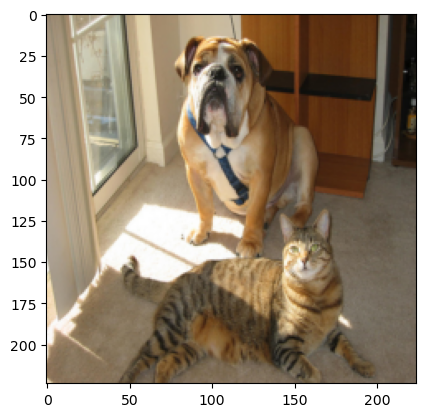


conv1
bn1
relu
maxpool
layer1
layer1.0
layer1.0.conv1
layer1.0.bn1
layer1.0.relu
layer1.0.conv2
layer1.0.bn2
layer1.1
layer1.1.conv1
layer1.1.bn1
layer1.1.relu
layer1.1.conv2
layer1.1.bn2
layer1.2
layer1.2.conv1
layer1.2.bn1
layer1.2.relu
layer1.2.conv2
layer1.2.bn2
layer2
layer2.0
layer2.0.conv1
layer2.0.bn1
layer2.0.relu
layer2.0.conv2
layer2.0.bn2
layer2.0.downsample
layer2.0.downsample.0
layer2.0.downsample.1
layer2.1
layer2.1.conv1
layer2.1.bn1
layer2.1.relu
layer2.1.conv2
layer2.1.bn2
layer2.2
layer2.2.conv1
layer2.2.bn1
layer2.2.relu
layer2.2.conv2
layer2.2.bn2
layer2.3
layer2.3.conv1
layer2.3.bn1
layer2.3.relu
layer2.3.conv2
layer2.3.bn2
layer3
layer3.0
layer3.0.conv1
layer3.0.bn1
layer3.0.relu
layer3.0.conv2
layer3.0.bn2
layer3.0.downsample
layer3.0.downsample.0
layer3.0.downsample.1
layer3.1
layer3.1.conv1
layer3.1.bn1
layer3.1.relu
layer3.1.conv2
layer3.1.bn2
layer3.2
layer3.2.conv1
layer3.2.bn1
layer3.2.relu
layer3.2.conv2
layer3.2.bn2
layer3.3
layer3.3.conv1
layer3.3.bn1


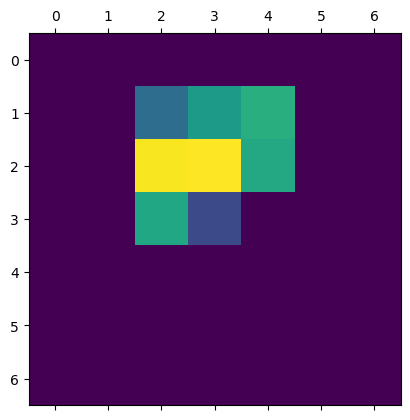

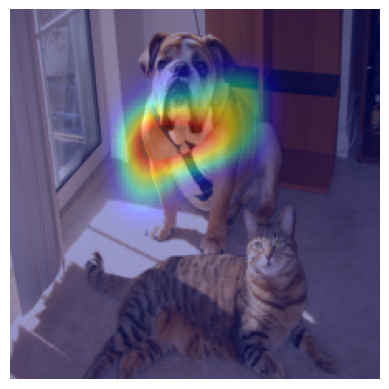

In [5]:
"""
Task 3.4: Grad-CAM
""" 

image = Image.open("./dataset/cat_dog.jpg")
trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
image = trans(image)

cat_dog = image.permute(1,2,0)

# cat_dog = torch.from_numpy(np.array(cat_dog))
plt.imshow(cat_dog)
plt.show()

model.eval()
loss_fn = nn.CrossEntropyLoss()
y_cat = torch.zeros(1000)
y_cat[242] = 1
features_in_hook = []
features_out_hook = []
gradients_in_hook = []
gradients_out_hook = []
def hook_forward(module, fea_in, fea_out):
    features_in_hook.append(fea_in)         # 勾的是指定层的输入
    # 只取前向传播的数值
    features_out_hook.append(fea_out)      # 勾的是指定层的输出
    return None
def hook_backward(module, grad_in, grad_out):
    # print(f"grad_in:{grad_in}")
    gradients_in_hook.append(grad_in)
    gradients_out_hook.append(grad_out)
    return None
layer_name = "layer4.2.conv1"
# layer_name = "layer4.2.conv2"
for (name, module) in model.named_modules():
    print(name)
    if name == layer_name:
        hf = module.register_forward_hook(hook=hook_forward)
        hb = module.register_backward_hook(hook=hook_backward)

logits = model.forward(cat_dog.permute([2,0,1]).unsqueeze(dim=0).type(torch.float).to(args["device"]))
hf.remove()
print(logits)
print(logits.shape)

# calculate gradient of each layer
# https://stackoverflow.com/questions/67722328/how-to-check-the-output-gradient-by-each-layer-in-pytorch-in-my-code
# https://discuss.pytorch.org/t/how-can-i-get-the-gradients-of-the-weights-of-each-layer/28502

# layer_name = "layer4.2.relu"
# for (name, module) in model.named_modules():
#     print(name)
#     if name == layer_name:
#         # hf = module.register_forward_hook(hook=hook_forward)
#         hb = module.register_full_backward_hook(hook=hook_backward)
# loss = loss_fn(logits, y_cat.to(args["device"]))
loss = logits @ y_cat.to(args['device'])
loss.backward()
hb.remove()
# print(model.layer4[2].relu.grad)
# print(model.layer4[2].relu.grad.shape)
print(features_out_hook[0].squeeze(dim=0))
print(features_out_hook[0].squeeze(dim=0).shape)
# print(features_out_hook[0].sum())
print(gradients_out_hook[0][0])
print(gradients_out_hook[0][0].shape)

alpha_cat = gradients_out_hook[0][0].mean(dim=[2,3], keepdim=True).squeeze(dim=0)
print(alpha_cat.shape)

L = F.relu(alpha_cat.mul(features_out_hook[0].squeeze(dim=0)).sum(dim=0))
print(L)
L /= torch.max(L)
plt.matshow(L.detach().cpu())

# 整合
from torchvision.transforms.functional import to_pil_image
from matplotlib import colormaps
fig, ax = plt.subplots()
ax.axis('off')

ax.imshow(to_pil_image(cat_dog.permute([2,0,1]), mode='RGB'))

overlay = to_pil_image(L.detach().cpu(), mode='F').resize((224, 224), resample=Image.BICUBIC)

cmap = colormaps['jet']
overlay = (255*cmap(np.asarray(overlay) ** 2)[:,:,:3]).astype(np.uint8)

ax.imshow(overlay, alpha=0.4, interpolation="nearest")

plt.show()